In [1]:
import os
import numpy as np
import pandas as pd
import torch
from scipy.special import softmax
import matplotlib.pyplot as plt
import seaborn as sns

from TorchCP.torchcp.classification.scores import THR
from TorchCP.torchcp.classification.predictors import SplitPredictor, ClusterPredictor

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/data/software/anaconda3/envs/faiss/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Follow the example

In [2]:
calib_logits = np.load("cache/caches/cifar100/calib/resnet18_logits.npy", allow_pickle=True)
calib_labels = np.load("cache/caches/cifar100/calib/resnet18_labels.npy", allow_pickle=True)
test_logits = np.load("cache/caches/cifar100/test/resnet18_logits.npy", allow_pickle=True)
test_labels = np.load("cache/caches/cifar100/test/resnet18_labels.npy", allow_pickle=True)
calib_logits = torch.tensor(calib_logits)
calib_labels = torch.tensor(calib_labels).long()
test_logits = torch.tensor(test_logits)
test_labels = torch.tensor(test_labels).long()

In [29]:
predictor = SplitPredictor(score_function=THR())
predictor.calculate_threshold(calib_logits, calib_labels, 0.01)
pred_sets = predictor.predict(test_logits)

In [4]:
print(f"coverage rate:{predictor._metric('coverage_rate')(pred_sets, test_labels)}")
print(f"average size:{predictor._metric('average_size')(pred_sets, test_labels)}")

coverage rate:0.992
average size:26.69


### Check whether atypicality affects prediction sets

In [5]:
import faiss

train_feature = np.load("cache/caches/cifar100/train/resnet18_feature.npy", allow_pickle=True)
test_feature = np.load("cache/caches/cifar100/test/resnet18_feature.npy", allow_pickle=True)
index = faiss.IndexFlatL2(train_feature.shape[1])
index.add(train_feature)
K = 20

D, _ = index.search(test_feature, K)
scores_in = D[:,-1]

In [6]:
probs = softmax(test_logits, 1)
atypicality = scores_in
labels = test_labels
pred_sets = pred_sets

records = []
quantiles = np.linspace(0, 1, 5)
for conf in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]:
    conf_lower = conf
    conf_upper = conf + 0.1
    i = 1
    for q_lower, q_higher in zip(quantiles[:-1], quantiles[1:]):
        prob_mask = ((np.max(probs, 1) >= conf_lower) & (np.max(probs, 1) <= conf_upper))
        if prob_mask.sum() != 0:
            vs = np.quantile(atypicality[prob_mask], q=[q_lower, q_higher])
            # Control for the start
            if q_lower == 0:
                vs[0] = -np.inf

            mask = ((atypicality <= vs[1]) & (atypicality > vs[0]) & (np.max(probs, 1) >= conf_lower)
                    & (np.max(probs, 1) <= conf_upper))
            group_probs = probs[mask]
            group_lbls = labels[mask]
            group_atypicality = atypicality[mask]
            group_pred_sets = [item for item, condition in zip(pred_sets, mask) if condition]

            if group_lbls.shape[0] != 0:
                record = {
                    "Accuracy": np.mean(np.argmax(group_probs, axis=1) == group_lbls),
                    "MeanAtypicality": i,
                    "confidence": f"{conf_lower}-{conf_upper}",
                    "Coverage rate": predictor._metric('coverage_rate')(group_pred_sets, group_lbls),
                    "Average size": predictor._metric('average_size')(group_pred_sets, group_lbls)
                }
                records.append(record)
                i += 1
records = pd.DataFrame(records)

Text(0.5, 1.0, 'CIFAR-10 - ResNet18')

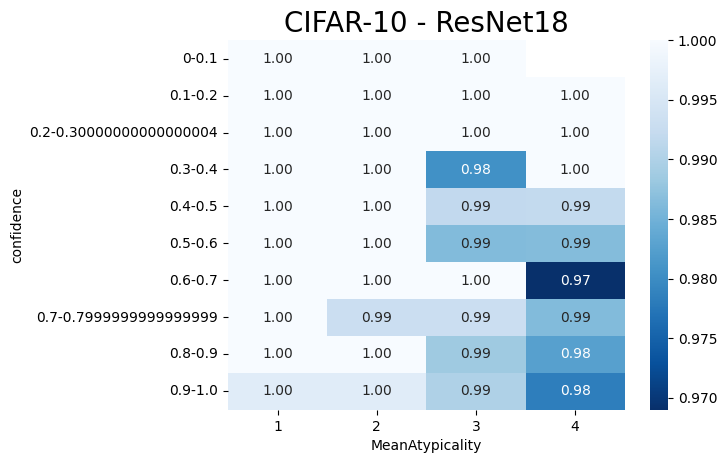

In [7]:
f, ax = plt.subplots()
pt = records.pivot_table(columns='MeanAtypicality', index='confidence', values='Coverage rate', aggfunc=np.sum)
ax = sns.heatmap(pt, annot=True, fmt=".2f", cmap="Blues_r")
ax.set_yticklabels(ax.get_yticklabels(), rotation=360)
ax.set_title("CIFAR-10 - ResNet18", fontsize=20)

### Use KNN to improve conformal prediction

In [72]:
calib_feature = np.load("cache/caches/cifar100/calib/resnet18_feature.npy", allow_pickle=True)
index = faiss.IndexFlatL2(calib_feature.shape[1])
index.add(calib_feature)
K = 1000

D, I = index.search(test_feature, K)
scores_in = D[:,-1]

In [73]:
predictor = SplitPredictor(score_function=THR())
pred_sets = []
for i in range(test_feature.shape[0]):
    predictor.calculate_threshold(calib_logits[I[i]], calib_labels[I[i]], alpha=0.01)
    pred_sets.append(predictor.predict(test_logits[i])[0])

In [74]:
import faiss

train_feature = np.load("cache/caches/cifar100/train/resnet18_feature.npy", allow_pickle=True)
test_feature = np.load("cache/caches/cifar100/test/resnet18_feature.npy", allow_pickle=True)
index = faiss.IndexFlatL2(train_feature.shape[1])
index.add(train_feature)
K = 20

D, _ = index.search(test_feature, K)
scores_in = D[:,-1]

probs = softmax(test_logits, 1)
atypicality = scores_in
labels = test_labels
pred_sets = pred_sets

records = []
quantiles = np.linspace(0, 1, 5)
for conf in [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]:
    conf_lower = conf
    conf_upper = conf + 0.1
    i = 1
    for q_lower, q_higher in zip(quantiles[:-1], quantiles[1:]):
        prob_mask = ((np.max(probs, 1) >= conf_lower) & (np.max(probs, 1) <= conf_upper))
        if prob_mask.sum() != 0:
            vs = np.quantile(atypicality[prob_mask], q=[q_lower, q_higher])
            # Control for the start
            if q_lower == 0:
                vs[0] = -np.inf

            mask = ((atypicality <= vs[1]) & (atypicality > vs[0]) & (np.max(probs, 1) >= conf_lower)
                    & (np.max(probs, 1) <= conf_upper))
            group_probs = probs[mask]
            group_lbls = labels[mask]
            group_atypicality = atypicality[mask]
            group_pred_sets = [item for item, condition in zip(pred_sets, mask) if condition]

            if group_lbls.shape[0] != 0:
                record = {
                    "Accuracy": np.mean(np.argmax(group_probs, axis=1) == group_lbls),
                    "MeanAtypicality": i,
                    "confidence": f"{conf_lower}-{conf_upper}",
                    "Coverage rate": predictor._metric('coverage_rate')(group_pred_sets, group_lbls),
                    "Average size": predictor._metric('average_size')(group_pred_sets, group_lbls)
                }
                records.append(record)
                i += 1
records = pd.DataFrame(records)

#### 寄！

Text(0.5, 1.0, 'CIFAR-10 - ResNet18')

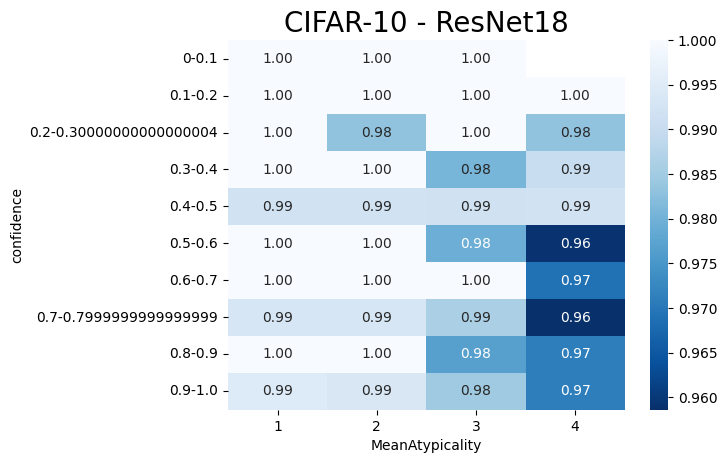

In [75]:
f, ax = plt.subplots()
pt = records.pivot_table(columns='MeanAtypicality', index='confidence', values='Coverage rate', aggfunc=np.sum)
ax = sns.heatmap(pt, annot=True, fmt=".2f", cmap="Blues_r")
ax.set_yticklabels(ax.get_yticklabels(), rotation=360)
ax.set_title("CIFAR-10 - ResNet18", fontsize=20)

### Use conformal score to detect OOD sample

In [25]:
svhn_logits = torch.tensor(np.load("cache/caches/svhn/test/resnet18_logits.npy", allow_pickle=True))
svhn_predictions = torch.argmax(svhn_logits, dim=1)
score_function = THR()
svhn_scores = score_function(svhn_logits, svhn_predictions)
svhn_scores

tensor([0.4871, 0.5158, 0.5074,  ..., 0.4999, 0.4638, 0.4681],
       dtype=torch.float64)

In [26]:
test_logits = torch.tensor(np.load("cache/caches/cifar10/test/resnet18_logits.npy", allow_pickle=True))
test_predictions = torch.argmax(test_logits, dim=1)
cifar_score = score_function(test_logits, test_predictions)
cifar_score

tensor([0.0107, 0.1835, 0.0048,  ..., 0.0080, 0.0009, 0.0007],
       dtype=torch.float64)

Text(0, 0.5, 'Density')

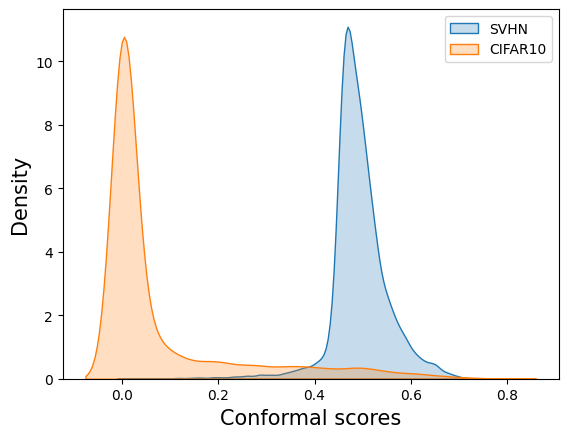

In [36]:
sns.kdeplot(svhn_scores, fill=True, label="SVHN")
sns.kdeplot(cifar_score, fill=True, label="CIFAR10")
plt.legend()
plt.xlabel("Conformal scores", fontsize=15)
plt.ylabel("Density", fontsize=15)